In [1]:
import numpy as np
import cupy as cp
from types import SimpleNamespace
from utils import *
import xraylib
import cv2

# Init data sizes and parameters 

In [2]:
n = 2048  # object size in each dimension
ntheta = 1  # number of angles (rotations)
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

ndist = 4 # number of distances from the focal spot in holotomography
detector_pixelsize = 3e-6 # detector pixel size
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # focus to detector distance [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0 # distances
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance # adjusted distances
magnifications = focusToDetectorDistance/z1 # magnifications
voxelsize = detector_pixelsize/magnifications[0]*2048/n/2  # object voxel size

norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = distances*norm_magnifications**2 # readjusted distances
z1p = z1[0]  # positions of the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnificationsp = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnifications2**2
distancesp = distancesp*(z1p/z1)**2

npsi = int(np.ceil(n/norm_magnifications[-1]/8))*8  # reconstructed object size based on magnification and detector size
print(distances+distancesp)


[0.00401308 0.00401308 0.00401308 0.00401308]


In [3]:
 
from cuda_kernels import *   
############################# Functionality for Propagation #########################
def _fwd_pad(f):
    """Fwd data padding"""
    [ntheta, n] = f.shape[:2]
    fpad = cp.zeros([ntheta, 2 * n, 2 * n], dtype="complex64")
    pad_kernel((int(cp.ceil(2 * n / 32)), int(cp.ceil(2 * n / 32)), ntheta), (32, 32, 1), (fpad, f, n, ntheta, 0))
    return fpad / 2

def D(psi, j):
    """Forward propagator"""
    big_psi = cp.empty([len(psi), n, n], dtype="complex64")
    # Fresnel kernels
    fx = cp.fft.fftfreq(n * 2, d=voxelsize).astype("float32")
    [fx, fy] = cp.meshgrid(fx, fx)
    fker = cp.empty([ndist, 2 * n, 2* n], dtype="complex64")
    fker = cp.exp(-1j * cp.pi * wavelength * distances[j] * (fx**2 + fy**2))
    
    ff = _fwd_pad(psi)
    ff *= 2
    ff = cp.fft.ifft2(cp.fft.fft2(ff) * fker)
    ff = ff[:, n // 2 : -n // 2, n // 2 : -n // 2]
    big_psi[:] = ff

    return big_psi

def D1(psi, j,os = 2):
    """Forward propagator"""
    big_psi = cp.empty([len(psi), n, n], dtype="complex64")
    # Fresnel kernels
    fx = cp.fft.fftfreq(n * os, d=voxelsize).astype("float32")
    [fx, fy] = cp.meshgrid(fx, fx)
    fker = cp.empty([ndist, os * n, os * n], dtype="complex64")
    fker = cp.exp(-1j * cp.pi * wavelength * distances[j] * (fx**2 + fy**2))
    ff = cp.pad(psi,((0,0),(os*n//2-n//2,os*n//2-n//2),(os*n//2-n//2,os*n//2-n//2)))        
    ff = cp.fft.ifft2(cp.fft.fft2(ff) * fker)
    ff = ff[:, os*n//2-n//2:os*n//2+n//2, os*n//2-n//2:os*n//2+n//2]
    big_psi[:] = ff

    return big_psi

def D2(psi, j):
    """Forward propagator"""
    big_psi = cp.empty([len(psi), n, n], dtype="complex64")
    # Fresnel kernels
    fx = cp.fft.fftfreq(n * 2, d=voxelsize).astype("float32")
    [fx, fy] = cp.meshgrid(fx, fx)
    fker = cp.empty([ndist, 2 * n, 2* n], dtype="complex64")
    fker = cp.exp(-1j * cp.pi * wavelength * distances[j] * (fx**2 + fy**2))
    
    ff = _fwd_pad(psi)
    ff *= 2
    v = cp.ones(2*n,dtype='float32')
    v[:n//2] = cp.sin(cp.linspace(0,1,n//2)*cp.pi/2)
    v[-n//2:] = cp.cos(cp.linspace(0,1,n//2)*cp.pi/2)
    v = cp.outer(v,v)
    ff*=v

    ff = cp.fft.ifft2(cp.fft.fft2(ff) * fker)
    ff = ff[:, n // 2 : -n // 2, n // 2 : -n // 2]
    big_psi[:] = ff
    return big_psi



## Read object and plot orthogonal views

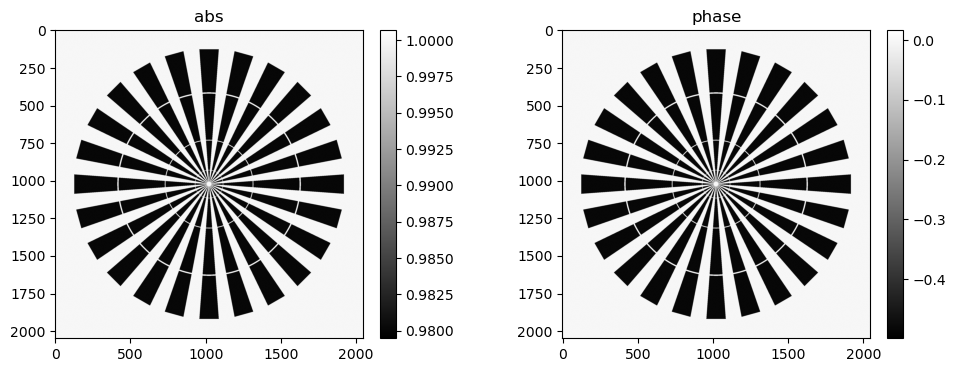

In [4]:
img = np.zeros((n, n, 3), np.uint8)
triangle = np.array([(n//16, n//2-n//32), (n//16, n//2+n//32), (n//2-n//128, n//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((n, n, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-n//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+n//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
x = x/n*2
y = y/n*2
# add holes in triangles
circ = (x**2+y**2>0.355)+(x**2+y**2<0.345)
circ *= (x**2+y**2>0.083)+(x**2+y**2<0.08)
circ *= (x**2+y**2>0.0085)+(x**2+y**2<0.008)
star = star*circ/255

v = np.arange(-n//2,n//2)/n
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-5*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 1e-6/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength)[np.newaxis].astype('complex64')


mshow_polar(psi[0],True)

In [5]:

prb_abs = read_tiff(f'../data/prb_id16a/prb_abs_2048.tiff')[0:1]
prb_phase = read_tiff(f'../data/prb_id16a/prb_phase_2048.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')


prb /= np.mean(np.abs(prb))
prb=cp.array(prb)
# v = np.arange(-(n+2*pad)//2,(n+2*pad)//2)/(n+2*pad)
# [vx,vy] = np.meshgrid(v,v)
# v=np.exp(-20*(vx**2+vy**2))
# prb = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(prb)))
# prb = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(prb*v)))
# prb = prb.astype('complex64')


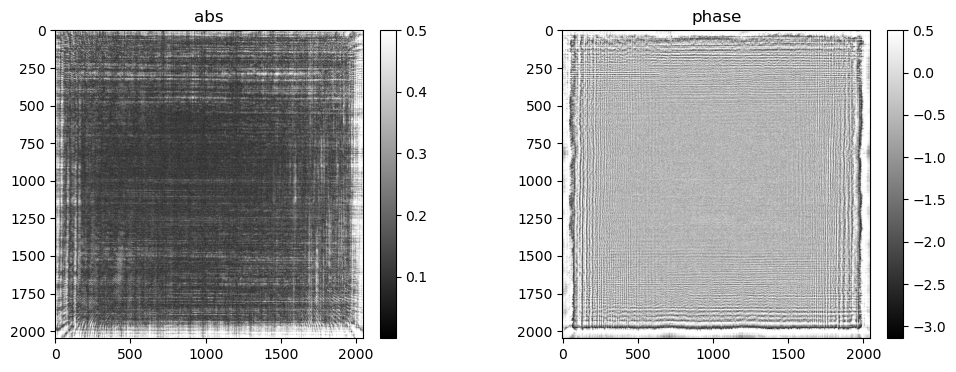

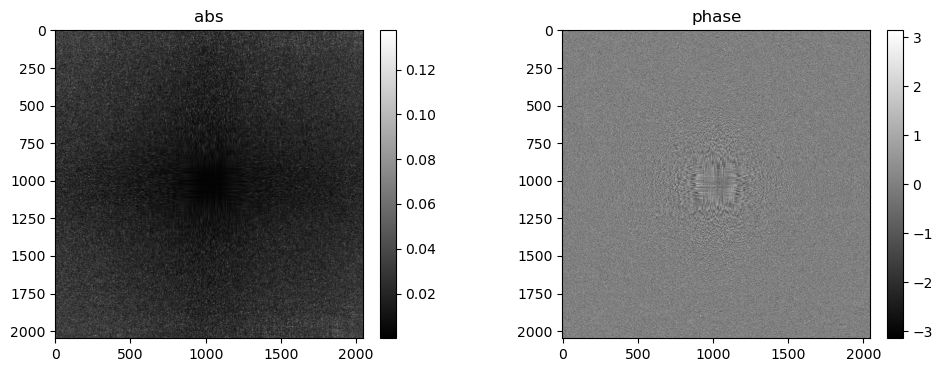

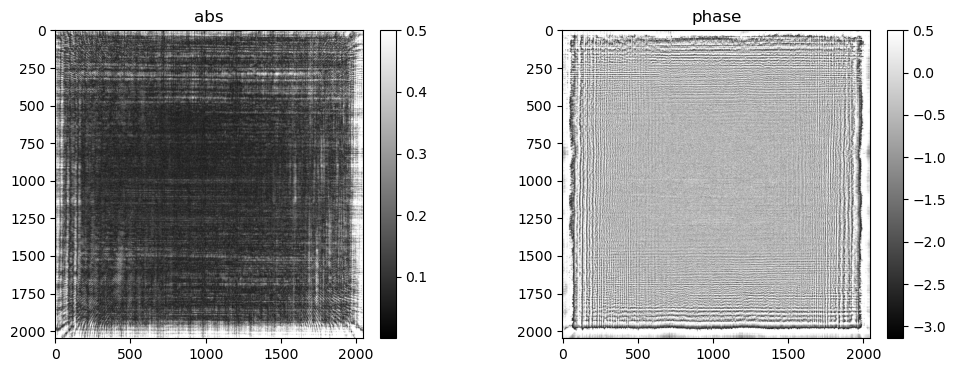

In [8]:
pp = cp.array(psi)*prb
a = D(pp,0)
b = D1(pp,0,2)
c = D1(pp,0,4)
d = D2(pp,0)
# mshow_polar(a[0],True)
# mshow_polar(b[0],True)
# mshow_polar(c[0],True)
# mshow_polar(d[0],True)
mshow_polar(a[0]-b[0],True,vmax=0.5)
mshow_polar(c[0]-b[0],True)
mshow_polar(d[0]-b[0],True,vmax=0.5)